In [80]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import spatial

In [81]:
# import data
EEPosition_new = np.load('logs/EEPosition_new.npy')
EEOrientation_new = np.load('logs/EEOrientation_new.npy')
EEQuaternion_new = np.load('logs/EEQuaternion_new.npy')
print(EEPosition_new.shape)

(1480245, 3)


# Load torso point cloud

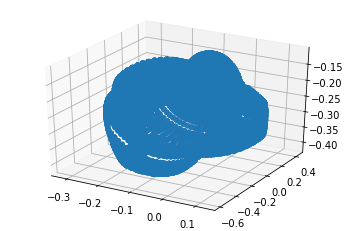

In [82]:
# point cloud
#vertices_mat = sio.loadmat(r'F:\Projects\ARClab\project_Dimitri\STLRead\Torso_vertices.mat')
vertices_mat = sio.loadmat(r'../STLRead/Torso_vertices.mat')
vertices = vertices_mat['V_rm']
# plot torso vertices
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_aspect('equal')
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2])
plt.show()

In [83]:
print('vertices.shape = ',vertices.shape)
print(vertices)

vertices.shape =  (45360, 3)
[[ 0.04750305 -0.37376733 -0.20942224]
 [ 0.04687695 -0.37470673 -0.20853253]
 [ 0.02889038 -0.4006416  -0.26561859]
 ...
 [-0.25083093 -0.32298627 -0.26958643]
 [-0.25671405 -0.34483698 -0.2715321 ]
 [-0.25681702 -0.3446535  -0.26961627]]


# Set a bounding box before KDtree to reduce computation time

In [84]:
# set bounding box
xmin = -0.3
xmax = 0.3
ymin = -0.6
ymax = 0.6
zmin = -0.3
zmax = 0

inbox_x = np.logical_and((-EEPosition_new[:,1]>xmin), (-EEPosition_new[:,1]<xmax))
inbox_y = np.logical_and((EEPosition_new[:,2]>ymin), (EEPosition_new[:,2]<ymax))
inbox_z = np.logical_and((-EEPosition_new[:,0]>zmin), (-EEPosition_new[:,0]<zmax))

# get points in box
inbox_xy = np.logical_and(inbox_x, inbox_y)
inbox_xyz = np.logical_and(inbox_xy, inbox_z)
#print(inbox_xyz)

EEPosition_new_inbox = EEPosition_new[inbox_xyz]
EEOrientation_new_inbox = EEOrientation_new[inbox_xyz]
EEQuaternion_new_inbox = EEQuaternion_new[inbox_xyz]

print('shape before bounding box: ', EEPosition_new.shape)
print('shape after bounding box: ', EEPosition_new_inbox.shape)

shape before bounding box:  (1480245, 3)
shape after bounding box:  (419280, 3)


In [85]:
# plot inbox points
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(-EEPosition_new_inbox[:,1], EEPosition_new_inbox[:,2], -EEPosition_new_inbox[:,0])
# plt.show()

# KDtree
### set sphere distance here

In [86]:
# KDtree
Points = list(zip(-EEPosition_new_inbox[:,1], EEPosition_new_inbox[:,2], -EEPosition_new_inbox[:,0]))
Points_torso = list(zip(vertices[:,0], vertices[:,1], vertices[:,2]))

kdtree = spatial.cKDTree(Points)
kdtree_torso = spatial.cKDTree(Points_torso)
ind = kdtree_torso.query_ball_tree(kdtree, 0.05) # set distance here

# Plot points near torso surface to check if they make sense

In [87]:
ind_flat = list(set([n for a in ind for n in a ]))   # unpack and remove redundant indices
# get points near torso
EEPosition_torso = EEPosition_new_inbox[ind_flat,:]
EEOrientation_torso = EEOrientation_new_inbox[ind_flat,:]
EEQuaternion_torso = EEQuaternion_new_inbox[ind_flat,:]
print('shape after KDtree: ', EEPosition_torso.shape)

shape after KDtree:  (106364, 3)


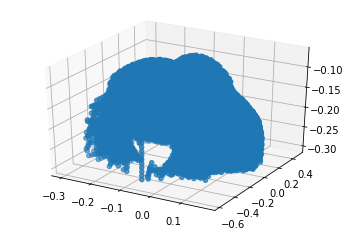

In [88]:
# plot torso points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-EEPosition_torso[:,1], EEPosition_torso[:,2], -EEPosition_torso[:,0])
plt.show()

# Creat an list 'num_bin' correponding to robot dexterity near each torso vertice

In [89]:
# create indexed vertices
index_list = np.indices((len(Points_torso),)).T
Indexed_Points_torso = np.asarray(Points_torso)
Indexed_Points_torso = np.hstack((index_list,Indexed_Points_torso))

In [90]:
Indexed_Points_torso = list(zip(Indexed_Points_torso[:,0], Indexed_Points_torso[:,1], Indexed_Points_torso[:,2], Indexed_Points_torso[:,3]))

In [91]:
from tqdm import tqdm_notebook as tqdm
pbar = tqdm(total=len(Indexed_Points_torso))  # set progress bar

# save EEquaternion near each torso vertice
hash_quaternion_torso = dict()
count = 0
for i in range(len(Indexed_Points_torso)):
#for i in range(50):
    key = Indexed_Points_torso[i]
    get_ind = ind[i]
    if len(get_ind)==0:
        hash_quaternion_torso[key] = []
    else:
        hash_quaternion_torso[key] = EEQuaternion_new_inbox[get_ind,:]
    pbar.update(1)
pbar.close()

In [92]:
# # save EEquaternion near each torso vertice
# hash_quaternion_torso = dict()
# count = 0
# for i in range(len(Points_torso)):
# #for i in range(50):
#     key = Points_torso[i]
#     get_ind = ind[i]
#     if len(get_ind)==0:
#         hash_quaternion_torso[key] = []
#     else:
#         hash_quaternion_torso[key] = EEQuaternion_new_inbox[get_ind,:]
# print(hash_quaternion_torso)

In [93]:
import transforms3d as t3d
import numpy as np

def quantizeOrientationsBins(numBins, quaternions):
    #numBins is per axis --> numBins**2
    #using spherical coordinates: https://en.wikipedia.org/wiki/Spherical_coordinate_system
    #theta 0 is - pi/2 to pi/2
    #phi is -pi to pi
    #orientations is in quaternions
    
    quaternions = np.roll(quaternions, 1).copy()#we need w, x, y, z; vrep uses x, y, z, w
    
    thetaInterval = np.linspace(-np.pi/2, np.pi/2, num=numBins+1)
    phiInterval = np.linspace(-np.pi, np.pi, num=numBins+1)
    
    spherical = np.zeros((quaternions.shape[0],2)) #phi, theta
    for i in range(spherical.shape[0]):
        # mod
        if quaternions.ndim != 1:
            rotMat = t3d.quaternions.quat2mat(quaternions[i,:])
        else:
            rotMat = t3d.quaternions.quat2mat(quaternions)
        cartesian = rotMat@np.ones((3,1))
        spherical[i,0] = np.arctan2(cartesian[1], cartesian[0]) # phi
        spherical[i,1] = np.arctan2(np.sqrt(cartesian[0]**2 + cartesian[1]**2), cartesian[2]) - np.pi/2 # theta
        
    binCounts = np.zeros((numBins,numBins))
    for i in range(numBins):
        for j in range(numBins):
            temp = np.stack((np.logical_and(spherical[:,1] > thetaInterval[i], spherical[:,1] < thetaInterval[i+1]),
                             np.logical_and(spherical[:,0] > phiInterval[j], spherical[:,0] < phiInterval[j+1])), axis = 1)
            #print(temp.shape)
            temp = temp.all(axis=1)
            binCounts[i,j] = np.sum(temp)
    return binCounts, spherical, temp, thetaInterval, phiInterval

### set number of bins here

In [94]:
pbar = tqdm(total=len(Indexed_Points_torso))  # set progress bar

# num_bin counts for different orientations near each torso vertice
num_bin = np.zeros((len(Indexed_Points_torso)))
count = 0
for i in hash_quaternion_torso:
    if len(hash_quaternion_torso[i]) == 0:
        num_bin[count] = 0
    else:
        binCounts, spherical, temp, thetaInterval, phiInterval = quantizeOrientationsBins(8, hash_quaternion_torso[i])  # !!!set number of bins
        binCounts[binCounts>0] = 1
        num_bin[count] = np.sum(binCounts)
    count += 1
    pbar.update(1)

pbar.close()

In [95]:
# save
np.save('logs/num_bin.npy',num_bin)
np.savetxt('logs/num_bin.csv', num_bin)

# Code below plots 2D heat map (not very interested)

In [96]:
# hash_quaternion_torso = dict()
# count = 0

# for i in Points_torso:
#     if i in hash_quaternion_torso:
#         value = hash_quaternion_torso[i]
#         hash_quaternion_torso[i] = np.vstack((value,EEQuaternion_torso[count,:]))
#     else:
#         hash_quaternion_torso[i] = np.array(EEQuaternion_torso[count,:])
#     count += 1
# print(hash_quaternion_torso)

In [97]:
# # plot torso plane
# x_torso = -EEPosition_torso[:,1]
# y_torso = EEPosition_torso[:,2]
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(x_torso, y_torso)
# plt.show()

In [98]:
# # plot heat map
# #hisat = np.histogramdd(data.T,bins=[5,5],density=True)
# %matplotlib inline
# hist, xedges, yedges = np.histogram2d(x_torso, y_torso, bins=20)
# plt.imshow(hist, extent=(np.amin(x_torso), np.amax(x_torso), np.amin(y_torso), np.amax(y_torso)))
# plt.colorbar()
# plt.show()

In [99]:
# # discretelize
# plane_res = 0.01
# xis = np.ceil((x_torso - xmin) / plane_res).astype(np.int16)-1
# yis = np.ceil((y_torso - ymin) / plane_res).astype(np.int16)-1
# print(xis)
# print(yis)

In [100]:
# # plot discrete
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(xis, yis,cmap="hot")
# plt.show()

In [101]:
# # map orientation inforation to each grid
# hash_orientation_torso = dict()
# count = 0
# for i in zip(xis,yis):
#     if i in hash_orientation_torso:
#         value = hash_orientation_torso[i]
#         hash_orientation_torso[i] = np.vstack((value,EEOrientation_torso[count,:]))
#     else:
#         hash_orientation_torso[i] = np.array(EEOrientation_torso[count,:])
#     count += 1
# print(hash_orientation_torso)

In [102]:
# result = {}

# for key,value in hash_orientation_torso:
#     if value not in result.values():
#         result[key] = value

# print(result)

In [103]:
# hash_orientation_torso_unique = dict()
# for key in hash_orientation_torso.keys():
#     print(hash_orientation_torso[key])
#     reList = hash_orientation_torso[key].tolist()
#     reList = list(set([tuple(t) for t in reList]))
#     reList = [list(v) for v in reList]
#     hash_orientation_torso_unique[key] = reList
# print(hash_orientation_torso_unique)